In [1]:
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

extraction_directory = 'extracted_images/'
y_train = pd.read_csv(extraction_directory + 'y_train.csv', index_col='id')
X_train = pd.read_csv(extraction_directory + 'X_train.csv', index_col='id')

In [2]:
class_distribution = y_train.apply(lambda x: {'Class ' + str(i): x[x == i].count() / X_train.shape[0] for i in range(4)})['y']
for name in class_distribution:
    print(name + ': {:.2%}'.format(class_distribution[name]))

Class 0: 59.21%
Class 1: 8.66%
Class 2: 28.81%
Class 3: 3.32%


In [14]:
X_train_downsampled = X_train.iloc[:,range(0, X_train.shape[1], 2)]

measure_length_downsampled = (-X_train_downsampled.T.isna()).sum().sort_values(ascending=True)

measure_length_downsampled

id
4613    1230
2384    1245
1941    1251
3754    1252
589     1305
        ... 
922     8837
985     8840
2102    8855
971     8856
3273    8904
Length: 5117, dtype: int64

In [4]:
import time

length = measure_length_downsampled.iloc[0]

start = time.time()

X_train1_np = np.zeros((measure_length_downsampled.shape[0], length))
X_train_downsampled_np = X_train_downsampled.to_numpy()

for ind in range(X_train_downsampled.shape[0]):
    first_timestep = (measure_length_downsampled.loc[X_train_downsampled.index[ind]] - length) // 2
    last_timestep = first_timestep + length
    X_train1_np[ind,:] = X_train_downsampled_np[ind,first_timestep:last_timestep]

X_train1 = pd.DataFrame(data=X_train1_np, index=X_train_downsampled.index)

end = time.time()
print(end - start)

0.06910896301269531


In [5]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_transformed_np = scaler.fit_transform(X_train1.to_numpy())

X_train_transformed = pd.DataFrame(data=X_train_transformed_np, index=X_train1.index)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Dropout, Conv1D, Flatten, MaxPooling1D, Input, Concatenate
from keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
import tensorflow as tf

/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
# Convert labels to categorical
y_train_cat_np = to_categorical(y_train.to_numpy())

# Split data
X_train_partial, X_val, y_train_partial, y_val = train_test_split(X_train_transformed_np, y_train_cat_np, test_size=0.2, random_state=23)

In [8]:
T = X_train_partial.shape[1]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [32, 16, 16, 24, 16, 8, 3]                # number of units in hidden and output layers
M_TRAIN = X_train_partial.shape[0]           # number of training examples (2D)
M_TEST = X_val.shape[0]             # number of test examples (2D),full=X_test.shape[0]
BATCH = M_TRAIN# // 8                          # batch size
EPOCH = 150                          # number of epochs
learning_rate = 5e-3                            # learning rate of the gradient descent
LAMBD = 3e-3                         # lambda in L2 regularizaion
dropout = 0.4                             # dropout rate
dropout_CNN = .5
recurrent_dropout = 0.0                            # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, val_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {1}, epochs = {EPOCH}')
print(f'learning_rate = {learning_rate}, lambda = {LAMBD}, dropout = {dropout}, recurrent_dropout = {recurrent_dropout}')

layers=[32, 16, 16, 24, 16, 8, 3], train_examples=4093, val_examples=1024
batch = 4093, timesteps = 1230, features = 1, epochs = 150
learning_rate = 0.005, lambda = 0.003, dropout = 0.4, recurrent_dropout = 0.0


In [9]:
# Build the Model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(T,1)))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=13, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=15, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(units=48, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=48, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=4, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],#, AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1,
                             verbose=0, 
                             factor=0.5,
                             min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=1500,
                           verbose=1,
                           mode='auto',
                           baseline=0,
                           restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1228, 32)          128       
                                                                 
 dropout (Dropout)           (None, 1228, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 614, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 610, 64)           10304     
                                                                 
 dropout_1 (Dropout)         (None, 610, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 305, 64)           0         
 g1D)                                                   

In [10]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=1500,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/1500
1/1 [==============================] - 4s 4s/step - loss: 1.8998 - accuracy: 0.2209 - val_loss: 1.3794 - val_accuracy: 0.4883
Epoch 2/1500
1/1 [==============================] - 2s 2s/step - loss: 1.7982 - accuracy: 0.2311 - val_loss: 1.4530 - val_accuracy: 0.0410
Epoch 3/1500
1/1 [==============================] - 2s 2s/step - loss: 1.7188 - accuracy: 0.2228 - val_loss: 1.7272 - val_accuracy: 0.0391
Epoch 4/1500
1/1 [==============================] - 2s 2s/step - loss: 1.6704 - accuracy: 0.2402 - val_loss: 2.2266 - val_accuracy: 0.0400
Epoch 5/1500
1/1 [==============================] - 2s 2s/step - loss: 1.6155 - accuracy: 0.2634 - val_loss: 2.5466 - val_accuracy: 0.0420
Epoch 6/1500
1/1 [==============================] - 2s 2s/step - loss: 1.5929 - accuracy: 0.2563 - val_loss: 2.9163 - val_accuracy: 0.0439
Epoch 7/1500
1/1 [==============================] - 2s 2s/step - loss: 1.5484 - accuracy: 0.2670 - val_loss: 2.9131 - val_accuracy: 0.0518
Epoch 8/1500
1/1 [=========

1/1 [==============================] - 0s 147ms/step - loss: 0.6868 - accuracy: 0.7637
-----------------------------------------------------------------
train accuracy = 86.6357%
test accuracy = 76.3672%


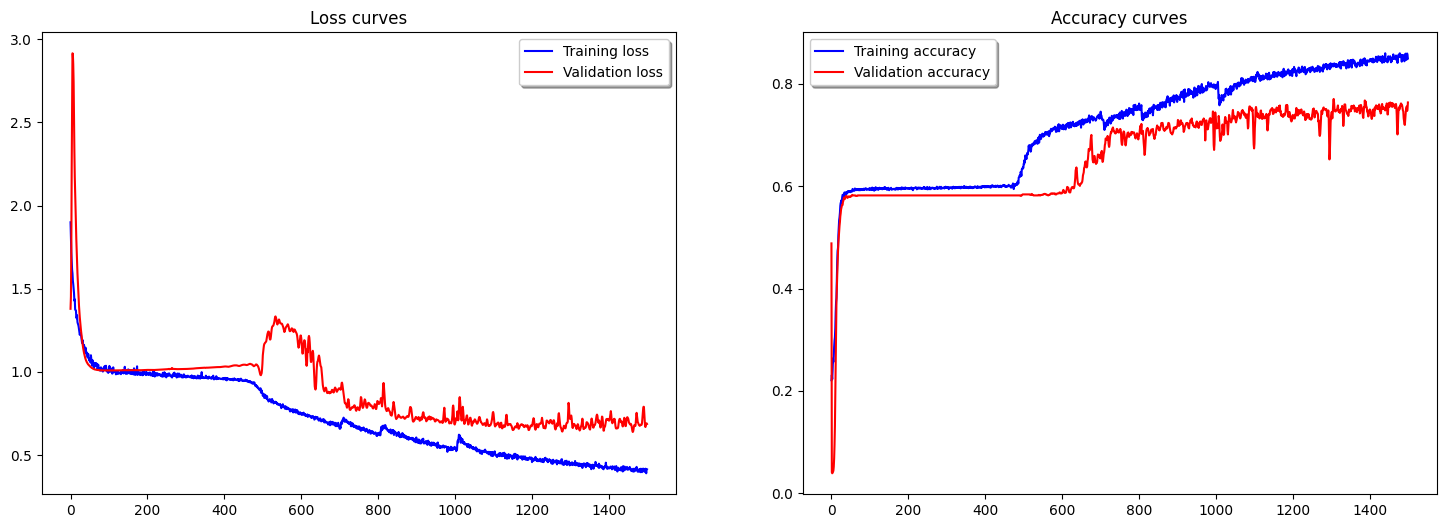

In [12]:
# Evaluate the model:
train_loss, train_accuracy = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_accuracy = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [13]:
y_pred = model.predict(X_val)
f1_score(y_val, to_categorical(y_pred.argmax(axis=1)), average='micro')

32/32 [==============================] - 0s 10ms/step


0.763671875

In [15]:
X_test = pd.read_csv(extraction_directory + 'X_test.csv', index_col='id')

X_test_downsampled = X_test.iloc[:,range(0, X_test.shape[1], 2)]
assert X_test_downsampled.shape[1] == X_train_downsampled.shape[1]

measure_length_test_downsampled = (-X_test_downsampled.T.isna()).sum().sort_values(ascending=True)

In [16]:
start = time.time()

X_test1_np = np.zeros((measure_length_test_downsampled.shape[0], length))
X_test_downsampled_np = X_test_downsampled.to_numpy()

for ind in range(X_test_downsampled.shape[0]):
    first_timestep = (measure_length_test_downsampled.loc[X_test_downsampled.index[ind]] - length) // 2
    last_timestep = first_timestep + length
    X_test1_np[ind,:] = X_test_downsampled_np[ind,first_timestep:last_timestep]

X_test1 = pd.DataFrame(data=X_test1_np, index=X_test_downsampled.index)

X_test_transformed_np = scaler.transform(X_test1)

end = time.time()
print(end - start)

0.0901792049407959


In [17]:
y_pred = model.predict(X_test_transformed_np)

y_pred_class_np = y_pred.argmax(axis=1)

sol = pd.DataFrame(data={'id': range(y_pred_class_np.shape[0]), 'y': y_pred_class_np})
sol.to_csv('sol_big2.csv', columns=['id', 'y'], index = False)

107/107 [==============================] - 1s 12ms/step


(array([2733.,    0.,    0.,  175.,    0.,    0.,  491.,    0.,    0.,
          12.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

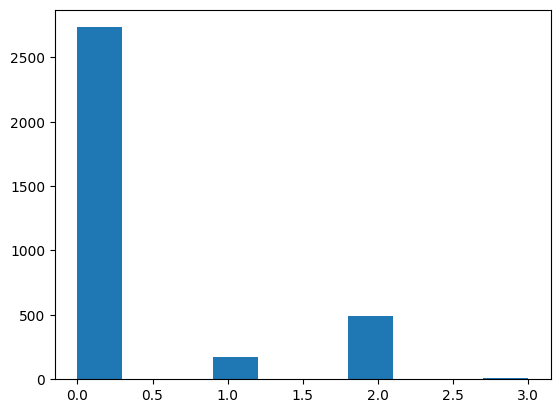

In [ ]:
plt.hist(y_pred_class_np)